# Failed Banks Information Assistant

### Load the required libraries

In [1]:
import time
from datetime import datetime
import os
import io

from PIL import Image
from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile

### Load the environment variables

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

### Create an AzureOpenAI client

In [3]:
client = AzureOpenAI(api_key=api_key,
        api_version=api_version,
        azure_endpoint=api_endpoint)

### Prepare the tools for function calling

In [4]:
tools_list = [
    {"type": "code_interpreter"},
]

In [5]:
DATA_FOLDER = "../data/banking/"
def upload_file(client, path):
    file = client.files.create(file=open(path, "rb"), purpose="assistants")
    return file

arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath =  DATA_FOLDER + file
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

In [6]:
assistant = client.beta.assistants.create(
    name="Failed Banks Assistant",
    instructions="You are an assistant that can help find information about failed banks. " +
    "Use the provided file only.",
    tools=tools_list, 
    model=api_deployment_name,
    file_ids=file_ids
)

thread = client.beta.threads.create()

In [7]:
def format_messages(messages):
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:                
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f'{message.role}:\n{item.text.value}\n')
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width //2, height //2), Image.LANCZOS)
                # Display image
                image.show()

In [8]:
def process_message(content:str):
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=content
    )

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + "."
    )
    
    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)            
            format_messages(messages)
            break        
        elif run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)            
            format_messages(messages)
            # Handle failed
            break
        elif run.status == "expired":
            # Handle expired
            break
        elif run.status == "cancelled":
            # Handle cancelled
            break
        elif run.status == "requires_action":
            pass
        else:
            #print("in progress...",run.status)
            time.sleep(5)

### Process user requests

processing...
user:
Create a chart of failed banks by state.

assistant:
To create a chart of failed banks by state, I will first need to examine the content of the file you uploaded to determine its format and the relevant data it contains. After examining the file, I'll be able to extract the necessary information and create the chart. Let's start by checking the file's format and content.

assistant:
The content appears to be in a comma-separated values (CSV) format, with each line representing a record and each record containing fields separated by commas. The fields include "Bank Name," "City," "State," "Cert" (likely a certificate number), "Acquiring Institution," "Closing Date," and "Fund."

Since the task is to create a chart of failed banks by state, we should focus on extracting the "State" field and counting the number of occurrences for each state. Then, we can create a bar chart that represents the number of failed banks in each state.

I will now proceed to read the data 

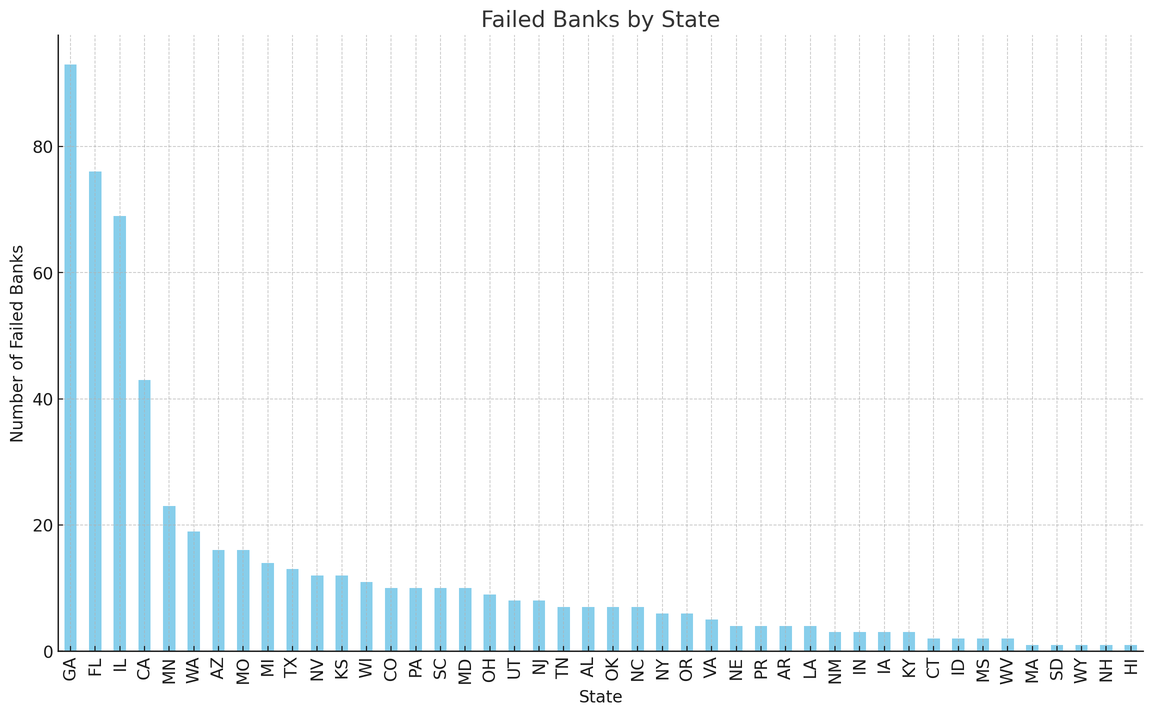

assistant:
Here is the bar chart depicting the number of failed banks by state. As shown, Georgia (GA) has the most failed banks, followed by Florida (FL) and Illinois (IL), among other states. Each bar represents a state, and the height of the bar indicates the number of failed banks in that particular state.



In [9]:
process_message("Create a chart of failed banks by state.")

In [10]:
process_message("What was the last bank to fail?")


processing...
user:
What was the last bank to fail?

assistant:
To identify the last bank to fail, we need to sort the data by the "Closing Date" column and then select the bank with the most recent date. We'll first convert the "Closing Date" column to datetime format to ensure proper sorting, and then find the last entry. Let's proceed with this task.

assistant:
The last bank to fail was "Citizens Bank," located in Sac City, Iowa (IA). It was closed on November 3, 2023, and the acquiring institution was "Iowa Trust & Savings Bank."



In [11]:
process_message("Which state has the most bank failures?")

processing...
user:
Which state has the most bank failures?

assistant:
As previously identified from the count of failed banks organized by state, Georgia (GA) has the most bank failures with a total of 93.



In [12]:
process_message("Which banks failed in Florida in between 2020-2023?")

processing...
user:
Which banks failed in Florida in between 2020-2023?

assistant:
Between 2020 and 2023, the following bank in Florida has failed:

- **Bank Name:** First City Bank of Florida
- **City:** Fort Walton Beach
- **Closing Date:** October 16, 2020

This is the only bank in Florida listed as having failed within that time range in the dataset provided.



### Cleanup

In [13]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)
for file in assistant_files:
    client.files.delete(file.id)